#### About
Wonders of the world image classification by transfer learning through fine tuning a Resnet model in PyTorch.
Dataset Link- https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import os
os.chdir('/content/drive/MyDrive/Datasets/')
! unzip wonders-of-world.zip

Archive:  wonders-of-world.zip
replace wonders-of-world/val/machu_pichu/0386.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import torch
from torch import Tensor
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import tarfile
#imports for loading images from the dataset structure
from torchvision.datasets import ImageFolder
from PIL import Image, ImageEnhance
import numpy as np
from torchvision import models
from torchsummary import summary
import time



In [2]:
#dataset is stored in seperate directory with label names inside train test for each of the classes.
root_dir="/content/drive/MyDrive/Datasets/wonders-of-world/"


In [3]:
#image enhancement function while training
enhancers = {
    0: lambda image, f: ImageEnhance.Color(image).enhance(f),
    1: lambda image, f: ImageEnhance.Contrast(image).enhance(f),
    2: lambda image, f: ImageEnhance.Brightness(image).enhance(f),
    3: lambda image, f: ImageEnhance.Sharpness(image).enhance(f)
}

factors = {
        0: lambda: np.random.normal(1.0, 0.3),
        1: lambda: np.random.normal(1.0, 0.1),
        2: lambda: np.random.normal(1.0, 0.1),
        3: lambda: np.random.normal(1.0, 0.3),
    }
    

def enhance(image):
    order = [0, 1, 2, 3]
    np.random.shuffle(order)
    for i in order:
        f = factors[i]()
        image = enhancers[i](image, f)
    return image

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224),Image.LANCZOS),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(enhance),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # ),
                                    ])


val_transform = transforms.Compose([
    #transforms.Resize(380, Image.LANCZOS),
    transforms.Resize((224, 224),Image.LANCZOS),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # ),
                                    ])

# standard deviation and mean values -
train_data = ImageFolder(root_dir+'/train', transform=train_transform)
val_data = ImageFolder(root_dir+'/val',transform=val_transform)


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [5]:
# let's have a look at the dataset dynamics
image,label = train_data[4]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
0


In [6]:
print(train_data.classes)
print(len(train_data.classes))

['burj_khalifa', 'chichen_itza', 'christ_the_reedemer', 'eiffel_tower', 'great_wall_of_china', 'machu_pichu', 'pyramids_of_giza', 'roman_colosseum', 'statue_of_liberty', 'stonehenge', 'taj_mahal', 'venezuela_angel_falls']
12


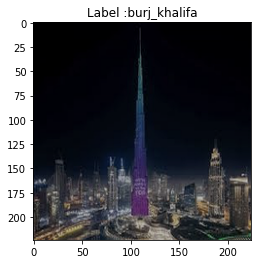

In [7]:
#Visualising data samples from train and test dataset
for i in range(232,233):
    image,label = train_data[i]
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(train_data.classes[label]))
    plt.show()

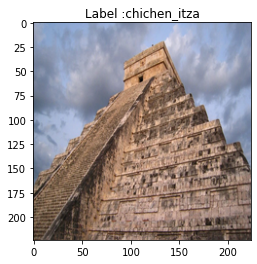

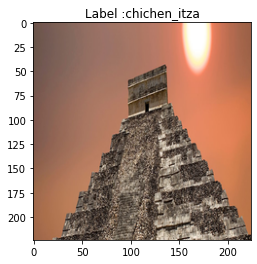

In [8]:
#Visualising data samples from train and test dataset
for i in range(10,12):
    image,label = val_data[i]
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(val_data.classes[label]))
    plt.show()

In [9]:
#creating dataloader
batch_size =64
train_loader = DataLoader(train_data,batch_size,shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size,shuffle=True,  num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
torch.cuda.is_available()

True

In [11]:
num_classes = len(train_data.classes)

In [12]:
resnet_model= models.resnet50(pretrained=True)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# # freezing models - use this for feature extraction based Transfer learning
# for param in resnet_model.parameters():
#     param.requires_grad = False

# #gradients will not be computed during backpropagation

In [15]:
# #popping out last_layer # use this for feature extraction based TL
# resnet_model.classifier[6] = nn.Linear(4096, num_classes)
# resnet_model.classifier.add_module("7",nn.LogSoftmax(dim=1))

In [16]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features,num_classes)


In [18]:
# defining the optimizer and loss function
loss_func = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(resnet_model.parameters())



In [19]:
def train_and_validate(model, loss_criterion, scheduler, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            #scheduler.step()

            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_data) 
        avg_train_acc = train_acc/len(train_data) 

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/len(val_data)  
        avg_valid_acc = valid_acc/len(val_data) 

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to("cuda")

num_epochs = 50
model, history = train_and_validate(resnet_model, loss_func, optimizer, num_epochs)

Epoch: 1/50
Epoch : 001, Training: Loss: 0.7110, Accuracy: 79.4561%, 
		Validation : Loss : 1.6241, Accuracy: 65.8333%, Time: 79.0166s
Epoch: 2/50
Epoch : 002, Training: Loss: 0.4851, Accuracy: 85.4335%, 
		Validation : Loss : 0.6309, Accuracy: 85.0000%, Time: 72.5014s
Epoch: 3/50
Epoch : 003, Training: Loss: 0.3563, Accuracy: 89.1222%, 
		Validation : Loss : 15.1901, Accuracy: 31.6667%, Time: 75.0597s
Epoch: 4/50
Epoch : 004, Training: Loss: 0.5859, Accuracy: 82.6333%, 
		Validation : Loss : 0.8989, Accuracy: 82.5000%, Time: 71.6710s
Epoch: 5/50
Epoch : 005, Training: Loss: 0.5046, Accuracy: 85.2719%, 
		Validation : Loss : 0.3050, Accuracy: 91.6667%, Time: 71.9161s
Epoch: 6/50
Epoch : 006, Training: Loss: 0.2994, Accuracy: 90.9262%, 
		Validation : Loss : 0.1710, Accuracy: 93.3333%, Time: 70.8990s
Epoch: 7/50
Epoch : 007, Training: Loss: 0.2934, Accuracy: 91.7340%, 
		Validation : Loss : 0.3789, Accuracy: 86.6667%, Time: 70.0909s
Epoch: 8/50
Epoch : 008, Training: Loss: 0.3667, Accur

In [21]:
#saving model
torch.save(resnet_model.state_dict(), 'resnet-wow.pth')

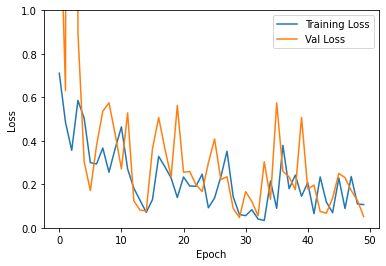

In [22]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

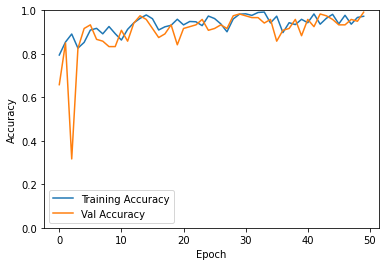

In [23]:
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [24]:
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
print(idx_to_class)


def predict(model, test_image_name):
    
    test_image = Image.open(test_image_name).convert('RGB')
    print(np.shape(test_image))
    plt.imshow(test_image)
    
    #mean = [0.485,0.485,0.485] 
    #std = [0.229,0.229,0.229]
    transform_norm = transforms.Compose([transforms.ToTensor(), 
          transforms.Resize((224,224)),transforms.Normalize(mean, std)])
    # get normalized image
    img_normalized = transform_norm(test_image).float()
    print(img_normalized.shape)

    if torch.cuda.is_available():
        test_image_tensor = img_normalized.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = img_normalized.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        prob = torch.exp(out)
        prob_, class_ = prob.topk(3, dim=1)
        class_ = class_.cpu().numpy()
        for i in range(3):
            print("Prediction", i+1, ":", idx_to_class[class_[0][i]], ", Score: ", prob_.cpu().numpy()[0][i])


{0: 'burj_khalifa', 1: 'chichen_itza', 2: 'christ_the_reedemer', 3: 'eiffel_tower', 4: 'great_wall_of_china', 5: 'machu_pichu', 6: 'pyramids_of_giza', 7: 'roman_colosseum', 8: 'statue_of_liberty', 9: 'stonehenge', 10: 'taj_mahal', 11: 'venezuela_angel_falls'}


(183, 275, 3)
torch.Size([3, 224, 224])
Prediction 1 : roman_colosseum , Score:  301.66547
Prediction 2 : taj_mahal , Score:  0.64710915
Prediction 3 : statue_of_liberty , Score:  0.51016474


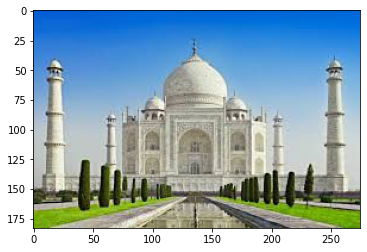

In [26]:
predict(model, '/content/drive/MyDrive/Datasets/wonders-of-world/val/taj_mahal/0157.jpg')
